In [1]:
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle
import sys
from json import loads

from contextual_bandit import ContextualBandit
from cascade_bandit import CascadeBandit
from damerau_levenshtien import damerau_levenshtein_distance

sys.path.append("../utils")
from pool_iterator import pool_iterator
from metric import calculate_metric
from json_tools import get_from_pool

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
n_objects = 569105

In [3]:
queries_counter = pickle.load(open("queries_counter", "rb"))
queries_by_word = pickle.load(open("queries_by_word", "rb"))

In [4]:
len(queries_counter)

459862

In [5]:
def parse_query(string):
    return tuple(map(int, string[1:-1].split(", ")))

In [6]:
%%time
nearest_queries = {}
with open("nearest_queries.txt") as handler:
    for i, line in enumerate(handler):
        parsed_line = loads(("{" + line.strip() + "}").replace('(', '"(').replace(')', ')"'))
        query_str = line[:line.find(":")]
        nearest_queries[parse_query(query_str)] = [
            parse_query(other_query)
            for other_query in parsed_line[query_str]
        ]

CPU times: user 4.9 s, sys: 60.5 ms, total: 4.96 s
Wall time: 4.92 s


In [7]:
%%time
position_variants = list(range(10)) + [100]
bandits_by_queries = {
    query: ContextualBandit(position_variants) for query in queries_counter
}
big_bandit = CascadeBandit(bandits_by_queries, nearest_queries)

CPU times: user 38.7 s, sys: 419 ms, total: 39.1 s
Wall time: 39.1 s


In [8]:
pool_filenames = [
    "../../../data/pool_with_queries/train_test_split/day_{}.json".format(i)
    for i in range(4)
]
train_pool_filenames = pool_filenames[:3]
test_pool = pool_filenames[3]

In [9]:
%%time
for pool_filename in train_pool_filenames:
    print(" fitting filename \"{}\"".format(pool_filename))
    for i, item in enumerate(pool_iterator(pool_filename)):
        if i % 10000 == 0:
            print(" {} %".format(round(400 * i / n_objects)))
        query = tuple(map(int, item["query"].split()))
        factors = item["factors"]
        reward = 1 if item["target"] > 0 else 0
        big_bandit.take_reward(query, item["pos"], reward, factors)

 fitting filename "../../../data/pool_with_queries/train_test_split/day_0.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
 fitting filename "../../../data/pool_with_queries/train_test_split/day_1.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
 fitting filename "../../../data/pool_with_queries/train_test_split/day_2.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
CPU times: user 7.59 s, sys: 206 ms, total: 7.8 s
Wall time: 7.34 s


In [10]:
%%time
targets_test = get_from_pool(pool_iterator(test_pool), "target", int)
probas_test = get_from_pool(pool_iterator(test_pool), "p", float)
positions_test = get_from_pool(pool_iterator(test_pool), "pos", int)

CPU times: user 3.98 s, sys: 39.8 ms, total: 4.02 s
Wall time: 4.02 s


In [11]:
%%time
thresholds = list(range(10, 100, 10)) + list(range(100, 300, 50))
answer_positions = {threshold: [] for threshold in thresholds}
for threshold in thresholds:
    print(" threshold ", threshold)
    for i, item in enumerate(pool_iterator(test_pool)):
        if i % 500 == 0:
            print(" {} %".format(round(i * 100 / len(positions_test))))
        query = tuple(map(int, item["query"].split()))
        context = item["factors"]
        answer_positions[threshold].append(
            big_bandit.get_action(query=query, context=context, statistic_threshold=threshold)
        )

 threshold  10
 0 %
 0 %
 1 %
 1 %
 1 %
 2 %
 2 %
 2 %
 3 %
 3 %
 4 %
 4 %
 4 %
 5 %
 5 %
 5 %
 6 %
 6 %
 6 %
 7 %
 7 %
 7 %
 8 %
 8 %
 8 %
 9 %
 9 %
 9 %
 10 %
 10 %
 11 %
 11 %
 11 %
 12 %
 12 %
 12 %
 13 %
 13 %
 13 %
 14 %
 14 %
 14 %
 15 %
 15 %
 15 %
 16 %
 16 %
 17 %
 17 %
 17 %
 18 %
 18 %
 18 %
 19 %
 19 %
 19 %
 20 %
 20 %
 20 %
 21 %
 21 %
 21 %
 22 %
 22 %
 22 %
 23 %
 23 %
 24 %
 24 %
 24 %
 25 %
 25 %
 25 %
 26 %
 26 %
 26 %
 27 %
 27 %
 27 %
 28 %
 28 %
 28 %
 29 %
 29 %
 30 %
 30 %
 30 %
 31 %
 31 %
 31 %
 32 %
 32 %
 32 %
 33 %
 33 %
 33 %
 34 %
 34 %
 34 %
 35 %
 35 %
 35 %
 36 %
 36 %
 37 %
 37 %
 37 %
 38 %
 38 %
 38 %
 39 %
 39 %
 39 %
 40 %
 40 %
 40 %
 41 %
 41 %
 41 %
 42 %
 42 %
 43 %
 43 %
 43 %
 44 %
 44 %
 44 %
 45 %
 45 %
 45 %
 46 %
 46 %
 46 %
 47 %
 47 %
 47 %
 48 %
 48 %
 48 %
 49 %
 49 %
 50 %
 50 %
 50 %
 51 %
 51 %
 51 %
 52 %
 52 %
 52 %
 53 %
 53 %
 53 %
 54 %
 54 %
 54 %
 55 %
 55 %
 56 %
 56 %
 56 %
 57 %
 57 %
 57 %
 58 %
 58 %
 58 %
 59 %
 59 %

 83 %
 83 %
 84 %
 84 %
 84 %
 85 %
 85 %
 85 %
 86 %
 86 %
 86 %
 87 %
 87 %
 88 %
 88 %
 88 %
 89 %
 89 %
 89 %
 90 %
 90 %
 90 %
 91 %
 91 %
 91 %
 92 %
 92 %
 92 %
 93 %
 93 %
 93 %
 94 %
 94 %
 95 %
 95 %
 95 %
 96 %
 96 %
 96 %
 97 %
 97 %
 97 %
 98 %
 98 %
 98 %
 99 %
 99 %
 99 %
 100 %
 threshold  60
 0 %
 0 %
 1 %
 1 %
 1 %
 2 %
 2 %
 2 %
 3 %
 3 %
 4 %
 4 %
 4 %
 5 %
 5 %
 5 %
 6 %
 6 %
 6 %
 7 %
 7 %
 7 %
 8 %
 8 %
 8 %
 9 %
 9 %
 9 %
 10 %
 10 %
 11 %
 11 %
 11 %
 12 %
 12 %
 12 %
 13 %
 13 %
 13 %
 14 %
 14 %
 14 %
 15 %
 15 %
 15 %
 16 %
 16 %
 17 %
 17 %
 17 %
 18 %
 18 %
 18 %
 19 %
 19 %
 19 %
 20 %
 20 %
 20 %
 21 %
 21 %
 21 %
 22 %
 22 %
 22 %
 23 %
 23 %
 24 %
 24 %
 24 %
 25 %
 25 %
 25 %
 26 %
 26 %
 26 %
 27 %
 27 %
 27 %
 28 %
 28 %
 28 %
 29 %
 29 %
 30 %
 30 %
 30 %
 31 %
 31 %
 31 %
 32 %
 32 %
 32 %
 33 %
 33 %
 33 %
 34 %
 34 %
 34 %
 35 %
 35 %
 35 %
 36 %
 36 %
 37 %
 37 %
 37 %
 38 %
 38 %
 38 %
 39 %
 39 %
 39 %
 40 %
 40 %
 40 %
 41 %
 41 %
 41 %
 42 

 66 %
 66 %
 66 %
 67 %
 67 %
 67 %
 68 %
 68 %
 69 %
 69 %
 69 %
 70 %
 70 %
 70 %
 71 %
 71 %
 71 %
 72 %
 72 %
 72 %
 73 %
 73 %
 73 %
 74 %
 74 %
 75 %
 75 %
 75 %
 76 %
 76 %
 76 %
 77 %
 77 %
 77 %
 78 %
 78 %
 78 %
 79 %
 79 %
 79 %
 80 %
 80 %
 80 %
 81 %
 81 %
 82 %
 82 %
 82 %
 83 %
 83 %
 83 %
 84 %
 84 %
 84 %
 85 %
 85 %
 85 %
 86 %
 86 %
 86 %
 87 %
 87 %
 88 %
 88 %
 88 %
 89 %
 89 %
 89 %
 90 %
 90 %
 90 %
 91 %
 91 %
 91 %
 92 %
 92 %
 92 %
 93 %
 93 %
 93 %
 94 %
 94 %
 95 %
 95 %
 95 %
 96 %
 96 %
 96 %
 97 %
 97 %
 97 %
 98 %
 98 %
 98 %
 99 %
 99 %
 99 %
 100 %
 threshold  150
 0 %
 0 %
 1 %
 1 %
 1 %
 2 %
 2 %
 2 %
 3 %
 3 %
 4 %
 4 %
 4 %
 5 %
 5 %
 5 %
 6 %
 6 %
 6 %
 7 %
 7 %
 7 %
 8 %
 8 %
 8 %
 9 %
 9 %
 9 %
 10 %
 10 %
 11 %
 11 %
 11 %
 12 %
 12 %
 12 %
 13 %
 13 %
 13 %
 14 %
 14 %
 14 %
 15 %
 15 %
 15 %
 16 %
 16 %
 17 %
 17 %
 17 %
 18 %
 18 %
 18 %
 19 %
 19 %
 19 %
 20 %
 20 %
 20 %
 21 %
 21 %
 21 %
 22 %
 22 %
 22 %
 23 %
 23 %
 24 %
 24 %
 24 %
 25

In [100]:
pickle.dump(answer_positions, open("non_contextial_bandits_answer_positions", "wb"))

In [12]:
%%time
statistics = []
for i, item in enumerate(pool_iterator(test_pool)):
    if i % 50000 == 0:
        print(" {} %".format(round(i * 100 / len(positions_test))))
    query = tuple(map(int, item["query"].split()))
    statistics.append(big_bandit.get_statistic_size(query))

 0 %
 35 %
 70 %
CPU times: user 1.82 s, sys: 18.5 ms, total: 1.84 s
Wall time: 1.81 s


In [39]:
statistics = np.array(statistics)
for threshold in thresholds:
    answer_positions[threshold] = np.array(answer_positions[threshold])

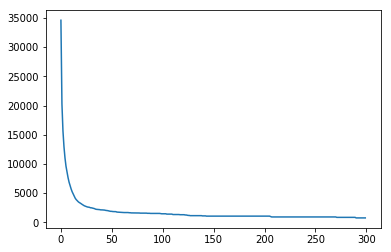

In [14]:
x = np.arange(max(statistics))
y = np.array([
    len(statistics[statistics > threshold])
    for threshold in x
])
plt.plot(x[:300], y[:300])

In [15]:
def compute_metric(threshold, answer):
    mask = (positions_test == answer) * (statistics > threshold)
    return np.sum(targets_test[mask] / probas_test[mask]) / np.sum(1 / probas_test[mask])

In [35]:
def compute_all_metric(threshold, answer):
    tmp_answer = np.copy(answer)
    tmp_answer[statistics < threshold] = 8
    return calculate_metric(
        tmp_answer,
        positions_test,
        targets_test,
        probas_test
    )

In [32]:
def plot_threshold(threshold, head, answer_positions):
    print(' threshold:', threshold)
    answer = answer_positions[threshold]

    axis = plt.gca()
    axis.set_title("Bandits metric")
    x = np.arange(max(statistics))
    y = np.array([
        compute_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[:head], y[:head])
    plt.show()

    axis = plt.gca()
    axis.set_title("All metric")
    y = np.array([
        compute_all_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[:head], y[:head])
    axis.set_ylim(0.62, 0.63)
    plt.show()

 threshold: 10


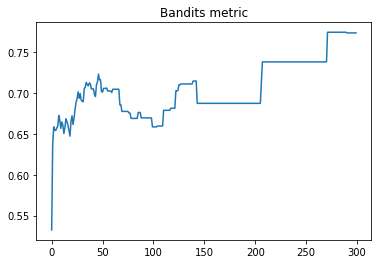

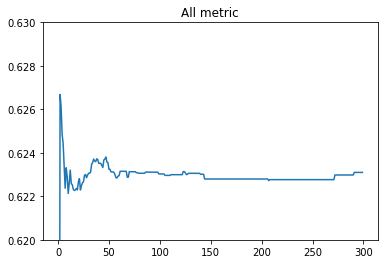

 threshold: 20


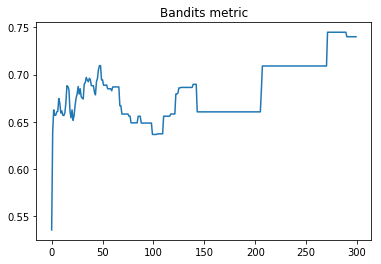

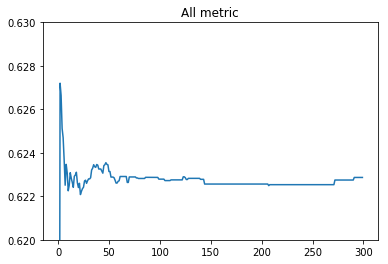

 threshold: 30


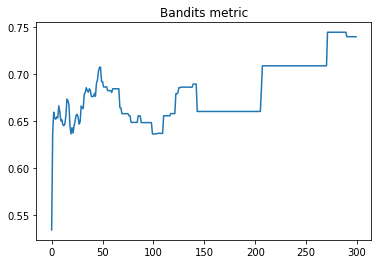

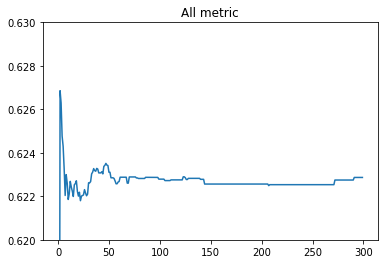

 threshold: 40


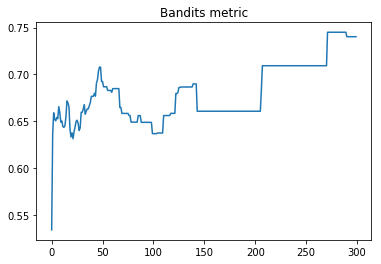

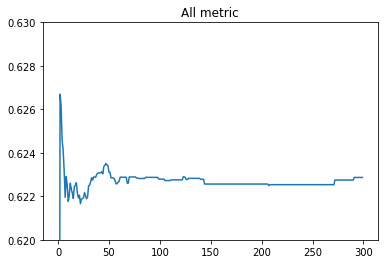

 threshold: 50


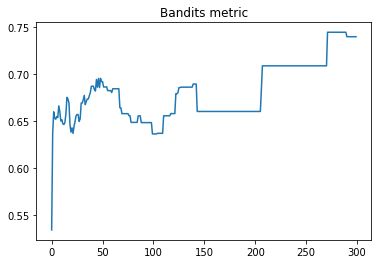

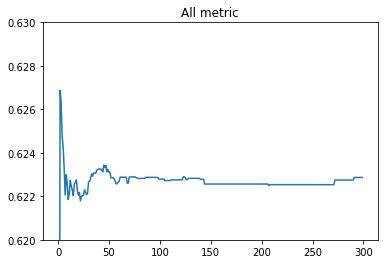

 threshold: 60


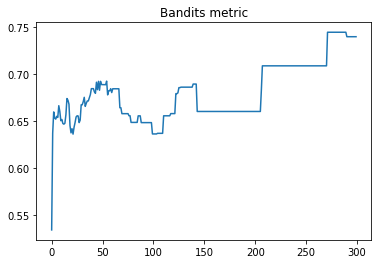

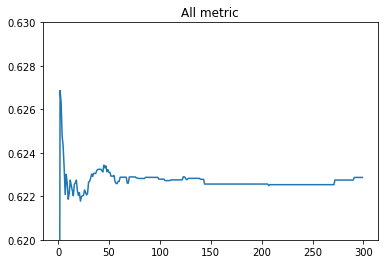

 threshold: 70


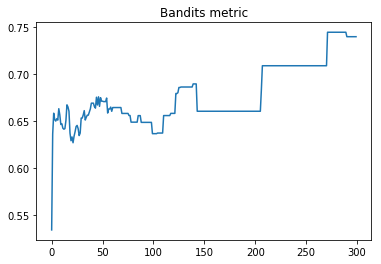

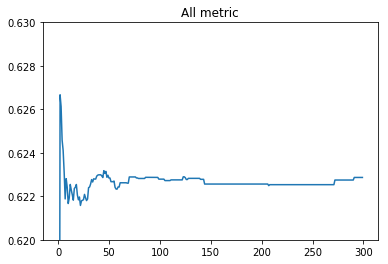

 threshold: 80


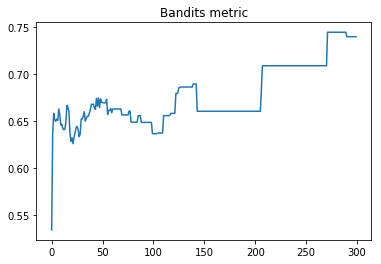

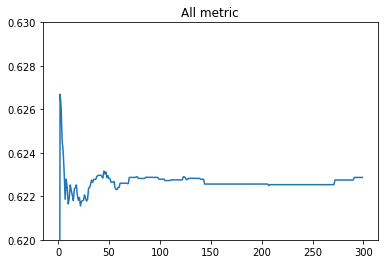

 threshold: 90


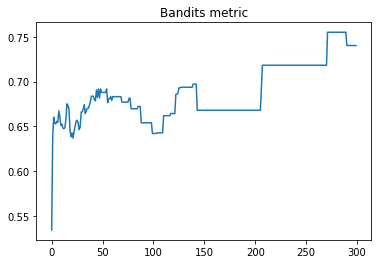

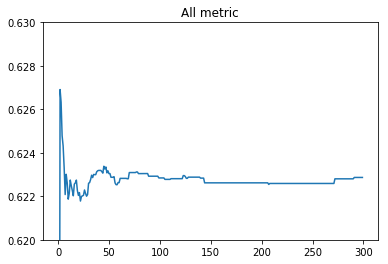

 threshold: 100


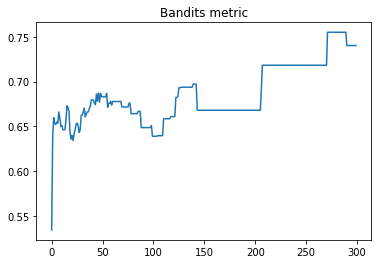

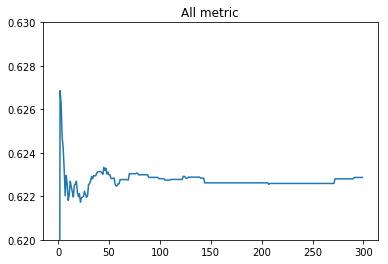

 threshold: 150


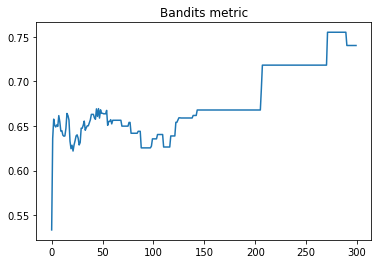

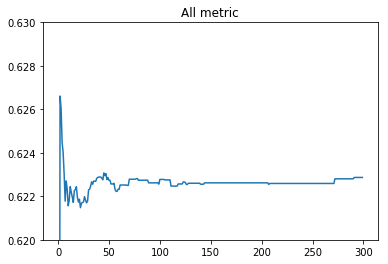

 threshold: 200


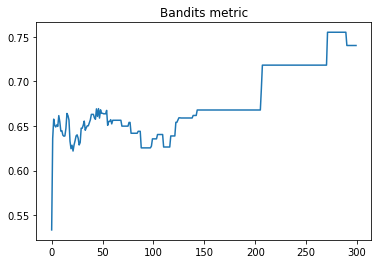

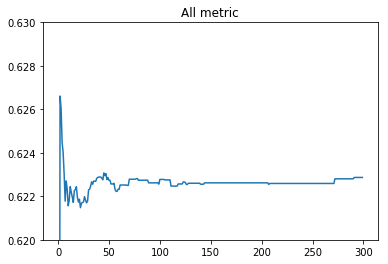

 threshold: 250


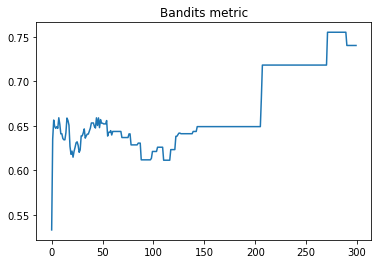

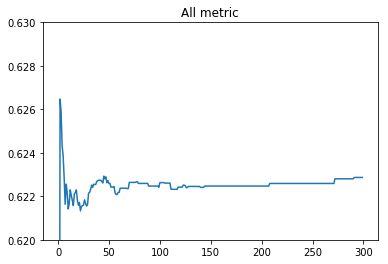

In [33]:
for threshold in thresholds:
    plot_threshold(threshold, 300, answer_positions)

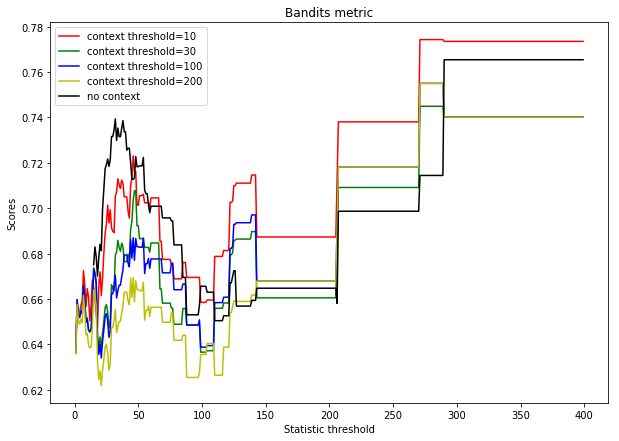

In [97]:
head = 400
plt.figure(figsize=(10, 7))
axis = plt.gca()
axis.set_title("Bandits metric")
for threshold, color in zip([10, 30, 100, 200], ['r', 'g', 'b', 'y']):
    answer = answer_positions[threshold]
    x = np.arange(max(statistics))
    y = np.array([
        compute_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[1:head], y[1:head], color=color, label="context threshold=" + str(threshold))

plt.plot(
    x[15:head],
    np.load("non_context_bandits_metrics.npy")[15:head],
    color='black', label="no context"
)
    
axis.set_xlabel('Statistic threshold')
axis.set_ylabel('Scores')
plt.legend()
plt.show()

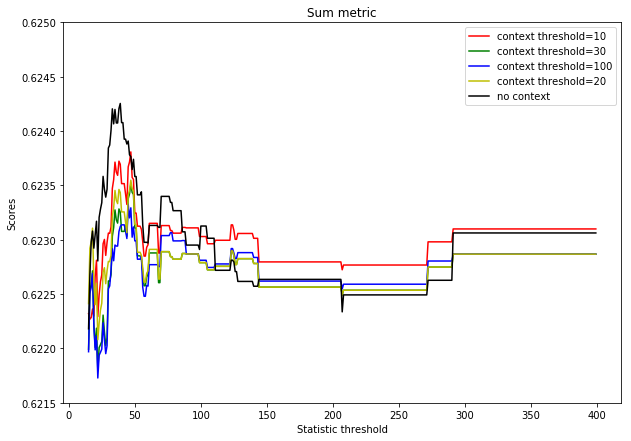

In [98]:
head = 400
plt.figure(figsize=(10, 7))
axis = plt.gca()
axis.set_title("Sum metric")
x = np.arange(max(statistics))
for threshold, color in zip([10, 30, 100, 20], ['r', 'g', 'b', 'y']):
    answer = answer_positions[threshold]
    y = np.array([
        compute_all_metric(tmp_threshold, answer)
        for tmp_threshold in x
    ])
    plt.plot(x[15:head], y[15:head], color=color, label="context threshold=" + str(threshold))
    
plt.plot(
    x[15:head],
    np.load("non_context_bandits_sum_metrics.npy")[15:head],
    color='black', label="no context"
)

axis.set_ylim(0.6215, 0.625)
axis.set_xlabel('Statistic threshold')
axis.set_ylabel('Scores')
plt.legend()
plt.show()

In [34]:
for i in list(range(10)) + [100]:
    print(' ', i, calculate_metric(
        [i] * len(probas_test),
        positions_test,
        targets_test,
        probas_test
    ))

  0 0.597785108388313
  1 0.6099456748850818
  2 0.612070331062886
  3 0.6208130328867236
  4 0.6088980858768753
  5 0.6147480419683761
  6 0.6207842854047808
  7 0.6103868347937592
  8 0.6226212619831162
  9 0.6197430316646771
  100 0.5989450003878676
